In [1]:
# Dependencies
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from modules.words import load_data

%matplotlib inline

# Constants
years = [2018, 2019]

# Load tweets dataset table
tweets = load_data('greta')

[nltk_data] Downloading package wordnet to /home/domenico/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/domenico/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Count occurrences of hashtags used as seeds\

In [16]:
def count_words_in_row(row, words_dict):
    """ 
    Conta una sola volta eventuali hashtag ripetuti. Bug o ok?
    """
    # Find the set of hashtags present in the tweet
    hash_tweet = set(re.findall(r"#(\w+)", row.text.lower()))
    hash_dict = set(words_dict.keys())
    # Update the number of hashtag in the dictionary
    for word in (hash_tweet & hash_dict):
        words_dict[word] += 1



def count_words_in_list(df, words_list):
    # Initialize the dictionary to store counts
    words_count = dict(zip(words_list, [0]*len(words_list)))
    # Scan each row updating the counters
    df.apply(count_words_in_row, words_dict=words_count, axis=1)
    
    return words_count

In [17]:
# 1st line: neutral hashtags
# 2nd line: specific hastags
words_list=["climatechange", "climatecrisis", "parisagreement", 
            "gretathunberg", "climatestrike", "fridays4future"]
                    
datasets = [tweets[tweets.created_at.dt.year == years[0]],
            tweets[tweets.created_at.dt.year == years[1]]]
            
for i, data in enumerate(datasets):
    print('hashtag frequencies in {}: \n\n'.format(years[i]), count_words_in_list(data, words_list), end = '\n\n')

hashtag frequencies in 2018: 

 {'climatechange': 8841, 'climatecrisis': 36, 'parisagreement': 1130, 'gretathunberg': 0, 'climatestrike': 0, 'fridays4future': 0}

hashtag frequencies in 2019: 

 {'climatechange': 6418, 'climatecrisis': 832, 'parisagreement': 202, 'gretathunberg': 146, 'climatestrike': 1646, 'fridays4future': 62}



## Find occurrences of all the used hashtags

In [39]:
def find_hash_distribution(row, d):
    # Find all the hashtag in the tweet
    hash_list = re.findall(r"#(\w+)", row.text.lower())
    
    # Increase the counter or define a new key with value 1
    for hashtag in hash_list:
        if hashtag in d: 
            d[hashtag] += 1
        else:
            d[hashtag] = 1



def plot_hash_distribution(df, n_hash_max, n_hash_min=0):
    # Initialize the dictionary to store counts
    hash_dict = {}
    # Scan each row of the df
    df.apply(find_hash_distribution, d=hash_dict, axis=1)
    
    # Convert the dictionary in a df, sort it by frequency
    hash_df = pd.DataFrame.from_dict(hash_dict.items())
    hash_df.columns = ["hashtag", "occurrences"]
    hash_df.sort_values(by="occurrences", ascending=False, inplace=True)

    # Plot the barplot with the specified interval of the most frequent hashtags
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    hash_df[n_hash_min : n_hash_max].plot(x="hashtag", y="occurrences", kind="bar", ax = ax)
    plt.show()
    
    return hash_df



def define_mask(row, mask, words):
    hash_tweet = set(re.findall(r"#(\w+)", row.text.lower()))
    mask.append((hash_tweet & words) != set())

    

def filter_dataset(df, words, year, n_max=25, n_min=1):
    """
    Return a dataframe that contains tweets in which is present at least 
    one hashtags in list "words" written in the specified year.
    """
    mask = []
    if words:
        tweets.apply(define_mask, mask=mask, words=set(words), axis=1)
    else:
        mask = True
    
    count_words_in_list(tweets[mask & (tweets.created_at.dt.year == year)], words_list)
    top_hash = plot_hash_distribution(tweets[mask & (tweets.created_at.dt.year == 2019)], 
                       n_hash_max=n_max, n_hash_min=n_min)
    
    return top_hash

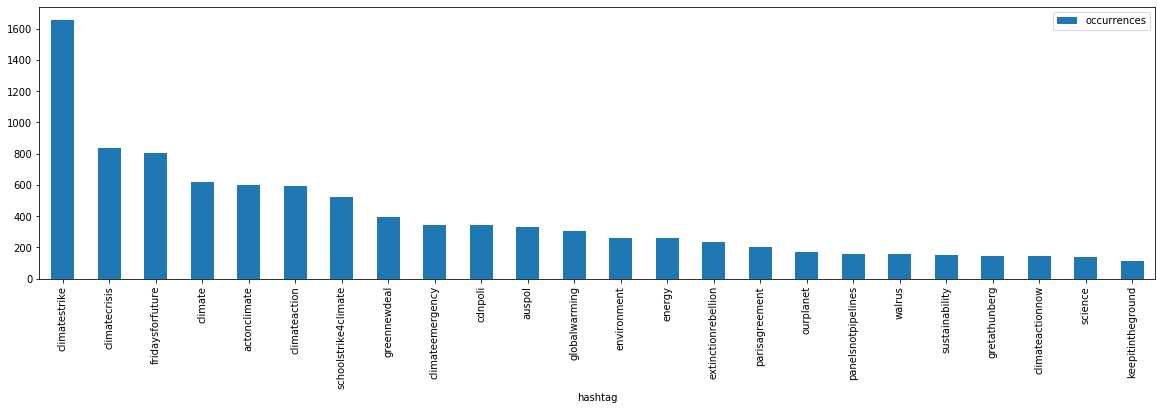

In [40]:
top_hash_pre = filter_dataset(tweets, words=[], year=2018, n_max=25, n_min=1)

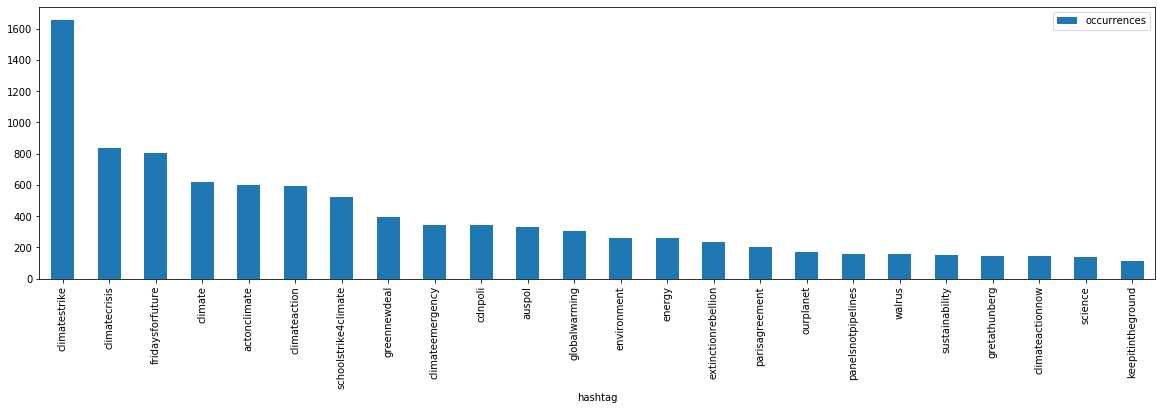

In [42]:
top_hash_post = filter_dataset(tweets, words=[], year=2019, n_max=25, n_min=1)

In [32]:
top_hash_post[top_hash_post.hashtag.isin(words_list)]

,hashtag,occurrences
1,climatechange,6466
5,climatestrike,1658
0,climatecrisis,836
115,parisagreement,203
53,gretathunberg,146
553,fridays4future,62
